In [1]:
import pickle
import numpy as np
from fastdtw import fastdtw
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind
%matplotlib inline

In [2]:
plt.style.use('seaborn-whitegrid')

In [3]:
def welch_satterthwaite(sample1, sample2):
    n1, n2 = len(sample1), len(sample2)
    s1, s2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)

    num = ((s1**2)/n1 + (s2**2)/n2)**2
    den = (s1**4)/(n1**3 - n1**2) + (s2**4)/(n2**3 - n2**2)
    return num/den

In [4]:
results_file = '../results/preliminary_results.pkl'
gini_file = './gini_1976_2014.csv'

In [5]:
actual_gini = np.genfromtxt(gini_file,delimiter=',', usecols=range(3,37), skip_header=2)

In [6]:
with open(results_file, 'rb') as file:
    results = pickle.load(file)

In [7]:
# LO_SRC, LO_TGT = min(results.keys()), 1.0
# HI_SRC, HI_TGT = max(results.keys()), 0.2
# bias2alpha = lambda b: LO_TGT + (b - LO_SRC)*(HI_TGT - LO_TGT)/(HI_SRC - LO_SRC)

In [8]:
# fig, ax = plt.subplots(figsize=(12,8))

# for bias, ginis in results.items():
#     ax.plot(ginis.index, ginis, label=f'Bias = {bias:.2f}', color='k', alpha=bias2alpha(bias))

# ax.set_ylim([0.0, 1.0])
# ax.tick_params(labelsize=18)
# ax.legend(ncol=2)
# plt.show()

In [9]:
alpha = 0.01
rejection = {}

for bias, gini in results.items():
    df = welch_satterthwaite(actual_gini, gini)
    t_crit = t.ppf(1-(alpha/2), df)
    t_test, pval = ttest_ind(actual_gini, gini, equal_var=False)
    
    print(f'\nBIAS: {bias:.2f}')
    print(f'\n\tDegrees of freedom: {df:.2f}')
    print(f'\n\tTest statistic: {t_test:.2f}')
    print(f'\n\tCritical value: {t_crit:.2f}')
    print(f'\n\tP-value.......: {pval:.2e}')
    result = 'H0 REJECTED.' if pval < alpha/2. else 'Failed to reject H0.'
    print(f'\n\tResult........: {result}')
    rejection[bias] = pval < alpha/2.



BIAS: -1.00

	Degrees of freedom: 52.69

	Test statistic: 6.40

	Critical value: 2.67

	P-value.......: 4.28e-08

	Result........: H0 REJECTED.

BIAS: -0.80

	Degrees of freedom: 53.66

	Test statistic: 4.74

	Critical value: 2.67

	P-value.......: 1.63e-05

	Result........: H0 REJECTED.

BIAS: -0.60

	Degrees of freedom: 51.81

	Test statistic: 2.80

	Critical value: 2.67

	P-value.......: 7.22e-03

	Result........: Failed to reject H0.

BIAS: -0.40

	Degrees of freedom: 55.35

	Test statistic: 2.12

	Critical value: 2.67

	P-value.......: 3.81e-02

	Result........: Failed to reject H0.

BIAS: -0.20

	Degrees of freedom: 58.84

	Test statistic: 1.21

	Critical value: 2.66

	P-value.......: 2.33e-01

	Result........: Failed to reject H0.

BIAS: 0.00

	Degrees of freedom: 56.43

	Test statistic: -0.79

	Critical value: 2.67

	P-value.......: 4.35e-01

	Result........: Failed to reject H0.

BIAS: 0.20

	Degrees of freedom: 59.93

	Test statistic: -1.64

	Critical value: 2.66

	P-value..

In [10]:
filtered_biases = [bias for bias, rej in rejection.items() if not rej]

In [11]:
costs = {bias: fastdtw(actual_gini, results[bias])[0] for bias in filtered_biases}

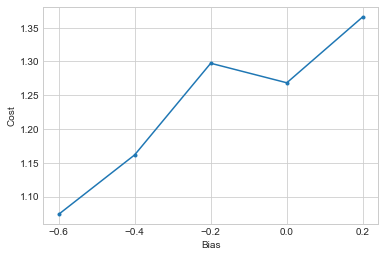

In [12]:
fig, ax = plt.subplots()

ax.plot(list(costs.keys()), list(costs.values()), marker='.')

ax.set_xlabel('Bias')
ax.set_ylabel('Cost')
ax.set_xticks(list(costs.keys()))
plt.show()

DTW: [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping)

- `fastdtw` [doc](https://pypi.org/project/fastdtw/).

In [13]:
selected_bias = min(costs, key=costs.get)

In [33]:
length = len(results[selected_bias])
selected_ginis = results[selected_bias]
padded_actual = np.pad(actual_gini, pad_width=(length - len(actual_gini))//2,
                       mode='constant', constant_values=(np.nan,))

In [34]:
len(padded_actual)

50

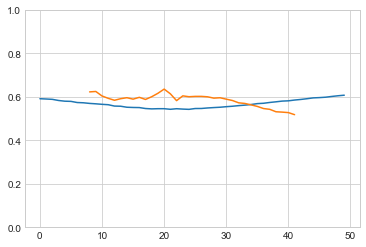

In [37]:
fig, ax = plt.subplots()

ax.plot(range(length), selected_ginis)
ax.plot(range(length), padded_actual)

ax.set_ylim([0.0, 1.0])

plt.show()